## Timit brute force test

Note that there is no 1:1 mapping for real to fake here for all files 

In [1]:
import opensmile 
import pandas as pd
import numpy as np
import os
import yaml
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel, SelectKBest, mutual_info_regression, SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, confusion_matrix, classification_report
import random
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from sklearn import svm
from pprint import pprint
from tqdm import tqdm
import pathlib
base_path = "/home/ubuntu/"

In [2]:
# Import configs
with open('/home/ubuntu/configs/config.yaml', 'r') as file:
    inputs = yaml.safe_load(file)

## Utility Functions:

In [3]:
def generate_confusion_matrix(y_test, yhat_test):
    
    #generate confusion matrix
    cm = confusion_matrix(y_test, yhat_test)

    #plot confusion matrix
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia_r)
    classNames = ['Real','Fake']
    plt.title('Real vs Fake Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
    plt.show()

In [4]:
def generate_ROC_curve(model, y_test, X_test):
    
    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(y_test))]
    # predict probabilities
    lr_probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # calculate scores
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Logistic: ROC AUC=%.3f\n' % (lr_auc))
    
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

In [5]:
def run_model_on_test_data(model, X_train, X_test, y_train, y_test, feature_index):
    
    #fit model
    model.fit(X_train[feature_index], y_train)
    
    #predict on held out test data
    yhat_train = model.predict(X_train[feature_index])
    yhat_test = model.predict(X_test[feature_index])
    
    #compute accuracy 
    accuracy_train = accuracy_score(y_train, yhat_train)
    accuracy_test = accuracy_score(y_test, yhat_test)
    
    #print
    print('<---- Train and Test Accuracy ---->\n')
    print('Logistic accuracy train = %.3f' % (accuracy_train*100))
    print('Logistic accuracy test = %.3f' % (accuracy_test*100))
    
    print('\n<---- Classification Report ---->\n')
    print(classification_report(y_test, yhat_test))
    
    print('\n<---- Confusion Matrix ---->\n')
    generate_confusion_matrix(y_test, yhat_test)
    
    print('\n<---- ROC-AUC ---->\n')
    generate_ROC_curve(model, y_test, X_test[feature_index]) 

## Importing TIMIT data

In [6]:
# Get resampled real and fake files
data_input_path = base_path + 'data/TIMIT_and_ElevenLabs/TIMIT and ElevenLabs/'

all_wav_files = pathlib.Path(data_input_path)
all_wav_files = list(all_wav_files.rglob("*.wav")) + list(all_wav_files.rglob("*.WAV"))

real_resampled_wav_files = [str(file) for file in all_wav_files if 'real' in str(file)]
fake_resampled_wav_files = [str(file) for file in all_wav_files if 'fake_processed' in str(file)]

In [7]:
# Get rid of folders that contain any wrong files
test_folders = []

for folder in os.listdir(data_input_path):
    phrase_files = [phrase for phrase in real_resampled_wav_files if folder in phrase]
    #phrase_files = [phrase for phrase in real_resampled_wav_files if f'_{folder}.' in phrase]
    #phrase_files = [phrase for phrase in phrase_files if f'/{folder}/' in phrase]
    
    file_names = set([name.split('_')[-1].split('.')[0] for name in phrase_files])
    
    if len(file_names) > 1:
        continue
    
    # Ensure each file has at least 2 real samples
    elif len(phrase_files) > 1:
        test_folders.append(folder)
print(len(test_folders))

149


In [8]:
real_files = []
fake_files = []

for folder in test_folders:
    real_path = os.path.join(data_input_path, folder, 'real')
    real_path = pathlib.Path(real_path)
    real_wav_files = list(real_path.rglob("*.wav")) + list(real_path.rglob("*.WAV"))
    [real_files.append(str(file)) for file in real_wav_files]
    
    fake_path = os.path.join(data_input_path, folder, 'fake_processed')
    fake_path = pathlib.Path(fake_path)
    fake_wav_files = list(fake_path.rglob("*.wav")) + list(fake_path.rglob("*.WAV"))
    [fake_files.append(str(file)) for file in fake_wav_files]

In [9]:
len(real_files), len(fake_files)

(1043, 1638)

### OpenSmile Feature Stuff

In [10]:
smile_functionals_ComParE = opensmile.Smile(
    feature_set=opensmile.FeatureSet.ComParE_2016,
    feature_level=opensmile.FeatureLevel.Functionals)

In [11]:
def generate_smile_df(path_list, smile_object):
    
    #path_list = get_path_list(folder_path)
    
    smile_df = pd.DataFrame()
    
    print("\nGenerating openSMILE features\n")
    
    for i in tqdm(range(len(path_list))):
        df = smile_object.process_file(path_list[i]).reset_index()
        
        duration = df['end'] - df['start']
        duration = duration.astype('timedelta64[ms]')/1000
        df.insert(loc=1, column='duration(seconds)', value=duration)
        
        df = df.rename(columns={'file':'path'})
        
        file = df.path.apply(lambda x:x.split('/')[-1])
        df.insert(loc=1, column='file', value=file)
        
        df.drop(columns=['start', 'end'], inplace=True)
        
        smile_df = pd.concat([smile_df, df])
    
    return smile_df

In [13]:
cellEnabled = 0
#cellEnabled = 1

savefile_timit = base_path + 'testing-code/opensmile-feature-importance/smile_dfs/' + '0320-SmileFeats-timit_data.csv'

if cellEnabled:
    
    
    real_sample = np.random.choice(real_files, 500, replace=False)
    fake_sample = np.random.choice(fake_files, 500, replace=False)

    real_df = generate_smile_df(real_sample, smile_functionals_ComParE)
    real_df.insert(loc=3, column='fake', value=0)

    fake_df = generate_smile_df(fake_sample, smile_functionals_ComParE)
    fake_df.insert(loc=3, column='fake', value=1)

    df = pd.concat([real_df, fake_df]).reset_index(drop=True)
    df.to_csv(savefile_timit, index=False)
    print("\nsaved to {}\n".format(savefile_timit)) 
    
if not cellEnabled:
    
    timit_df = pd.read_csv(savefile_timit)

In [14]:
timit_df

,path,file,duration(seconds),fake,audspec_lengthL1norm_sma_range,audspec_lengthL1norm_sma_maxPos,audspec_lengthL1norm_sma_minPos,audspec_lengthL1norm_sma_quartile1,audspec_lengthL1norm_sma_quartile2,audspec_lengthL1norm_sma_quartile3,...,mfcc_sma_de[14]_peakRangeAbs,mfcc_sma_de[14]_peakRangeRel,mfcc_sma_de[14]_peakMeanAbs,mfcc_sma_de[14]_peakMeanMeanDist,mfcc_sma_de[14]_peakMeanRel,mfcc_sma_de[14]_minRangeRel,mfcc_sma_de[14]_meanRisingSlope,mfcc_sma_de[14]_stddevRisingSlope,mfcc_sma_de[14]_meanFallingSlope,mfcc_sma_de[14]_stddevFallingSlope
0,/home/ubuntu/data/TIMIT_and_ElevenLabs/TIMIT a...,FLMA0_SX73.WAV,2.571,0,2.838317,0.313253,0.244980,0.345931,0.568772,0.843745,...,6.813305,0.560686,2.548323,2.562370,-19.845003,0.558314,112.931786,54.482506,119.628590,66.864680
1,/home/ubuntu/data/TIMIT_and_ElevenLabs/TIMIT a...,MPRD0_SX261.WAV,1.698,0,3.611201,0.203704,0.506173,0.427885,1.135267,1.839824,...,9.608778,0.613537,3.135098,3.185017,-18.529854,0.299265,121.677220,63.673244,141.333000,86.090730
2,/home/ubuntu/data/TIMIT_and_ElevenLabs/TIMIT a...,MSRR0_SX411.WAV,2.750,0,3.189846,0.168539,0.842697,0.547316,1.067395,1.702248,...,8.145550,0.527166,3.385799,3.366091,19.820385,0.503597,141.737610,80.650480,138.931900,62.792130
3,/home/ubuntu/data/TIMIT_and_ElevenLabs/TIMIT a...,MCXM0_SX451.WAV,3.825,0,2.214276,0.483957,0.016043,0.581879,0.977791,1.599527,...,8.244315,0.635483,2.638399,2.639529,-20.000000,0.423198,110.933430,63.077038,107.487510,46.867130
4,/home/ubuntu/data/TIMIT_and_ElevenLabs/TIMIT a...,FPLS0_SX330.WAV,2.753,0,3.365931,0.037453,0.411985,0.542019,0.922154,1.585083,...,7.312347,0.533022,2.874447,2.886742,-19.926113,0.531958,101.756870,57.085087,96.104560,45.216595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,/home/ubuntu/data/TIMIT_and_ElevenLabs/TIMIT a...,Obama_SX414.wav,2.831,1,2.727109,0.094545,0.018182,0.389225,0.692102,1.145348,...,5.193777,0.446817,2.628982,2.593500,18.882622,0.537746,104.114750,47.274060,113.677020,40.645990
996,/home/ubuntu/data/TIMIT_and_ElevenLabs/TIMIT a...,Bella_SX255.wav,2.327,1,3.021942,0.031111,0.791111,0.494164,0.744374,0.970743,...,6.429120,0.532331,2.440849,2.519576,-16.280357,0.579713,121.083916,61.543182,116.620290,56.983510
997,/home/ubuntu/data/TIMIT_and_ElevenLabs/TIMIT a...,Bella_SX300.wav,2.165,1,3.248069,0.004785,0.598086,0.480772,0.899916,1.238072,...,5.791419,0.517253,2.466377,2.446830,19.614693,0.667725,131.486530,47.092030,118.619840,48.441624
998,/home/ubuntu/data/TIMIT_and_ElevenLabs/TIMIT a...,Obama_SX117.wav,2.212,1,3.033282,0.169014,0.056338,0.386510,1.012344,1.618466,...,7.163714,0.460902,2.766320,2.795009,-19.315552,0.553126,121.760080,69.166240,119.256836,94.212860


## Train-Dev-Test Split:

In [15]:
def process_data(df):
    
    train_df, test_df = train_test_split(df, test_size=0.1, shuffle=True, random_state=45)
    train_df, dev_df = train_test_split(train_df, test_size=0.1, shuffle=True, random_state=45)
    
    exp_data_scaler = StandardScaler()
    train_df.iloc[:,4:] = exp_data_scaler.fit_transform(train_df.iloc[:,4:])
    dev_df.iloc[:,4:] = exp_data_scaler.transform(dev_df.iloc[:,4:])
    test_df.iloc[:,4:] = exp_data_scaler.transform(test_df.iloc[:,4:])
    
    X_train = train_df.drop(columns=['path', 'file', 'duration(seconds)', 'fake']).copy()
    y_train = train_df['fake'].copy()

    X_dev = dev_df.drop(columns=['path', 'file', 'duration(seconds)', 'fake'])
    y_dev = dev_df['fake'].copy()

    X_test = test_df.drop(columns=['path', 'file', 'duration(seconds)', 'fake'])
    y_test = test_df['fake'].copy()
    
    return X_train, y_train, X_dev, y_dev, X_test, y_test

In [16]:
X_train, y_train, X_dev, y_dev, X_test, y_test = process_data(timit_df)

## Brute-Force feature selection:

In [19]:
def run_bflr(X_train, y_train, X_dev, y_dev):
    
    train_accuracies = []
    dev_accuracies = []
    
    for i in tqdm(range(6373)):
        
        model_lr = LogisticRegression()
        model_lr.fit(X_train.iloc[:,i].to_numpy().reshape(-1, 1), y_train)
        y_hat_train = model_lr.predict(X_train.iloc[:,i].to_numpy().reshape(-1, 1))
        y_hat_dev = model_lr.predict(X_dev.iloc[:,i].to_numpy().reshape(-1, 1))
        train_accuracy = accuracy_score(y_train, y_hat_train)
        train_accuracies.append(train_accuracy)        
        dev_accuracy = accuracy_score(y_dev, y_hat_dev)
        dev_accuracies.append(dev_accuracy)
    
    print("\nAverage train accuracy: {}".format(np.mean(train_accuracies)))
    print("Average dev accuracy: {}\n".format(np.mean(dev_accuracies)))
    
    return dev_accuracies

In [20]:
def run_bfsvm(X_train, y_train, X_dev, y_dev):
    
    train_accuracies = []
    dev_accuracies = []
    
    for i in tqdm(range(6373)):
        
        model_svm = svm.SVC(probability=True)
        model_svm.fit(X_train.iloc[:,i].to_numpy().reshape(-1, 1), y_train)
        y_hat_train = model_svm.predict(X_train.iloc[:,i].to_numpy().reshape(-1, 1))
        y_hat_dev = model_svm.predict(X_dev.iloc[:,i].to_numpy().reshape(-1, 1))
        train_accuracy = accuracy_score(y_train, y_hat_train)
        train_accuracies.append(train_accuracy)        
        dev_accuracy = accuracy_score(y_dev, y_hat_dev)
        dev_accuracies.append(dev_accuracy)
    
    print("\nAverage train accuracy: {}".format(np.mean(train_accuracies)))
    print("Average dev accuracy: {}\n".format(np.mean(dev_accuracies)))
    
    return dev_accuracies

In [23]:
features = timit_df.columns.to_list()[4:]
bruteforce_df = pd.DataFrame(features, columns=['features'])
bruteforce_df['timit_lr'] = run_bflr(X_train, y_train, X_dev, y_dev)
bruteforce_df['timit_svm'] = run_bfsvm(X_train, y_train, X_dev, y_dev)
bruteforce_df['mean_dev_accuracies'] = bruteforce_df.iloc[:,1:].mean(axis=1)

100%|██████████| 6373/6373 [00:12<00:00, 522.31it/s]



Average train accuracy: 0.567159292772557
Average dev accuracy: 0.5570601670240772



100%|██████████| 6373/6373 [14:46<00:00,  7.19it/s]


Average train accuracy: 0.5822505438646449
Average dev accuracy: 0.5678278152623045



In [24]:
bruteforce_df.head()

,features,timit_lr,timit_svm,mean_dev_accuracies
0,audspec_lengthL1norm_sma_range,0.566667,0.533333,0.550000
1,audspec_lengthL1norm_sma_maxPos,0.577778,0.555556,0.566667
2,audspec_lengthL1norm_sma_minPos,0.466667,0.488889,0.477778
3,audspec_lengthL1norm_sma_quartile1,0.755556,0.766667,0.761111
4,audspec_lengthL1norm_sma_quartile2,0.700000,0.700000,0.700000


#### Results

In [48]:
bruteforce_df[(bruteforce_df.iloc[:,1:] > 0.92).all(axis=1)].sort_values(by='mean_dev_accuracies', ascending=False)

,features,timit_lr,timit_svm,mean_dev_accuracies
5242,mfcc_sma[4]_peakMeanAbs,0.944444,0.933333,0.938889
3110,pcm_fftMag_spectralKurtosis_sma_de_percentile99.0,0.933333,0.933333,0.933333
5074,pcm_fftMag_spectralKurtosis_sma_amean,0.933333,0.933333,0.933333
1405,pcm_fftMag_spectralKurtosis_sma_percentile99.0,0.922222,0.933333,0.927778
1406,pcm_fftMag_spectralKurtosis_sma_pctlrange0-1,0.922222,0.933333,0.927778
3111,pcm_fftMag_spectralKurtosis_sma_de_pctlrange0-1,0.933333,0.922222,0.927778
5076,pcm_fftMag_spectralKurtosis_sma_rqmean,0.933333,0.922222,0.927778
5085,pcm_fftMag_spectralKurtosis_sma_meanRisingSlope,0.922222,0.933333,0.927778
6108,pcm_fftMag_spectralKurtosis_sma_de_peakRangeAbs,0.922222,0.933333,0.927778
1617,mfcc_sma[4]_quartile3,0.922222,0.922222,0.922222


In [36]:
bruteforce_df[(bruteforce_df.iloc[:,1:] > 0.92).any(axis=1)]

,features,timit_lr,timit_svm,mean_dev_accuracies
1395,pcm_fftMag_spectralKurtosis_sma_range,0.911111,0.922222,0.916667
1405,pcm_fftMag_spectralKurtosis_sma_percentile99.0,0.922222,0.933333,0.927778
1406,pcm_fftMag_spectralKurtosis_sma_pctlrange0-1,0.922222,0.933333,0.927778
1407,pcm_fftMag_spectralKurtosis_sma_stddev,0.933333,0.911111,0.922222
1616,mfcc_sma[4]_quartile2,0.922222,0.911111,0.916667
1617,mfcc_sma[4]_quartile3,0.922222,0.922222,0.922222
3100,pcm_fftMag_spectralKurtosis_sma_de_range,0.911111,0.933333,0.922222
3109,pcm_fftMag_spectralKurtosis_sma_de_percentile1.0,0.922222,0.911111,0.916667
3110,pcm_fftMag_spectralKurtosis_sma_de_percentile99.0,0.933333,0.933333,0.933333
3111,pcm_fftMag_spectralKurtosis_sma_de_pctlrange0-1,0.933333,0.922222,0.927778


In [31]:
bruteforce_df[(bruteforce_df["features"].str.contains("zcr")) & (bruteforce_df.iloc[:,1:] > 0.80).any(axis=1)]

,features,timit_lr,timit_svm,mean_dev_accuracies
96,pcm_zcr_sma_quartile1,0.777778,0.844444,0.811111
102,pcm_zcr_sma_percentile1.0,0.888889,0.900000,0.894444


In [80]:
#pcm_zcr_sma_percentile
bruteforce_df[(bruteforce_df["features"].str.contains("pcm_zcr_sma")) & (bruteforce_df.iloc[:,1:] > 0.7).any(axis=1)]

,features,timit_lr,timit_svm,mean_dev_accuracies
96,pcm_zcr_sma_quartile1,0.777778,0.844444,0.811111
97,pcm_zcr_sma_quartile2,0.700000,0.755556,0.727778
98,pcm_zcr_sma_quartile3,0.666667,0.722222,0.694444
102,pcm_zcr_sma_percentile1.0,0.888889,0.900000,0.894444
104,pcm_zcr_sma_pctlrange0-1,0.711111,0.700000,0.705556
112,pcm_zcr_sma_upleveltime25,0.711111,0.688889,0.700000
4201,pcm_zcr_sma_flatness,0.800000,0.777778,0.788889
4209,pcm_zcr_sma_peakMeanRel,0.733333,0.755556,0.744444


In [37]:
bruteforce_df[(bruteforce_df["features"].str.contains("mfcc")) & (bruteforce_df.iloc[:,1:] > 0.80).any(axis=1)]

,features,timit_lr,timit_svm,mean_dev_accuracies
1553,mfcc_sma[2]_quartile1,0.855556,0.866667,0.861111
1554,mfcc_sma[2]_quartile2,0.888889,0.877778,0.883333
1555,mfcc_sma[2]_quartile3,0.888889,0.888889,0.888889
1560,mfcc_sma[2]_percentile99.0,0.877778,0.900000,0.888889
1615,mfcc_sma[4]_quartile1,0.911111,0.888889,0.900000
1616,mfcc_sma[4]_quartile2,0.922222,0.911111,0.916667
1617,mfcc_sma[4]_quartile3,0.922222,0.922222,0.922222
1622,mfcc_sma[4]_percentile99.0,0.877778,0.866667,0.872222
5189,mfcc_sma[2]_amean,0.888889,0.900000,0.894444
5196,mfcc_sma[2]_peakMeanAbs,0.888889,0.900000,0.894444


In [46]:
bruteforce_df[(bruteforce_df["features"].str.contains("shimmer")) & (bruteforce_df.iloc[:,1:] > 0.65).all(axis=1)]

,features,timit_lr,timit_svm,mean_dev_accuracies
3814,shimmerLocal_sma_amean,0.722222,0.722222,0.722222
3816,shimmerLocal_sma_posamean,0.722222,0.722222,0.722222
3817,shimmerLocal_sma_rqmean,0.666667,0.666667,0.666667
3823,shimmerLocal_sma_linregerrQ,0.666667,0.666667,0.666667
3827,shimmerLocal_sma_qregerrQ,0.688889,0.700000,0.694444
3829,shimmerLocal_sma_quartile1,0.700000,0.677778,0.688889
3830,shimmerLocal_sma_quartile2,0.722222,0.711111,0.716667
3831,shimmerLocal_sma_quartile3,0.677778,0.677778,0.677778
3832,shimmerLocal_sma_iqr1-2,0.688889,0.688889,0.688889
3834,shimmerLocal_sma_iqr1-3,0.688889,0.688889,0.688889


In [47]:
bruteforce_df[(bruteforce_df["features"].str.contains("jitter")) & (bruteforce_df.iloc[:,1:] > 0.65).all(axis=1)]

,features,timit_lr,timit_svm,mean_dev_accuracies
3979,jitterLocal_sma_de_linregerrQ,0.688889,0.666667,0.677778
3980,jitterLocal_sma_de_qregc1,0.655556,0.655556,0.655556
4016,jitterDDP_sma_de_linregc1,0.677778,0.677778,0.677778
4020,jitterDDP_sma_de_qregc2,0.655556,0.655556,0.655556


## Test on held out


In [50]:
selected_features = bruteforce_df[(bruteforce_df.iloc[:,1:] > 0.92).all(axis=1)]['features']
selected_features

1405       pcm_fftMag_spectralKurtosis_sma_percentile99.0
1406         pcm_fftMag_spectralKurtosis_sma_pctlrange0-1
1617                                mfcc_sma[4]_quartile3
3110    pcm_fftMag_spectralKurtosis_sma_de_percentile99.0
3111      pcm_fftMag_spectralKurtosis_sma_de_pctlrange0-1
5074                pcm_fftMag_spectralKurtosis_sma_amean
5076               pcm_fftMag_spectralKurtosis_sma_rqmean
5085      pcm_fftMag_spectralKurtosis_sma_meanRisingSlope
5242                              mfcc_sma[4]_peakMeanAbs
6108      pcm_fftMag_spectralKurtosis_sma_de_peakRangeAbs
Name: features, dtype: object

In [51]:
X_train_final = pd.concat([X_train, X_dev])
y_train_final = pd.concat([y_train, y_dev])

In [54]:
#select features identified from brute force
feature_index_1 = timit_df.columns.intersection(selected_features)

<---- Train and Test Accuracy ---->

Logistic accuracy train = 96.667
Logistic accuracy test = 94.000

<---- Classification Report ---->

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        55
           1       0.93      0.93      0.93        45

    accuracy                           0.94       100
   macro avg       0.94      0.94      0.94       100
weighted avg       0.94      0.94      0.94       100


<---- Confusion Matrix ---->



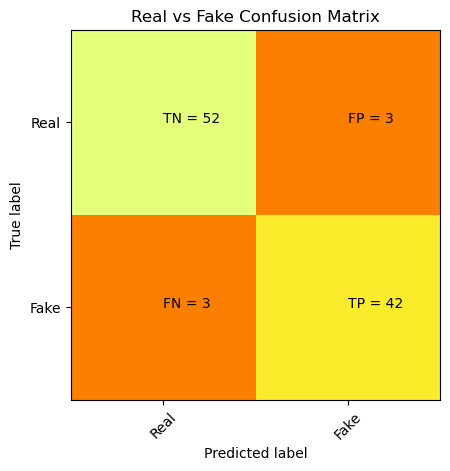


<---- ROC-AUC ---->

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.994



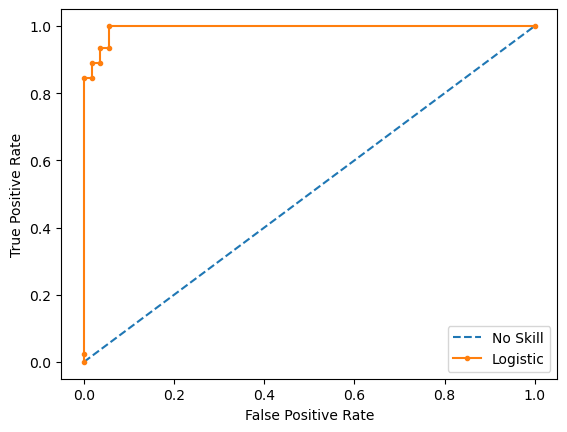

In [55]:
#run model on 16k
model_svm_1 = svm.SVC(probability=True)
run_model_on_test_data(model_svm_1, X_train_final, X_test, y_train_final, y_test, feature_index_1)

In [60]:
selected_features_2 = bruteforce_df[(bruteforce_df.iloc[:,1:] > 0.90).any(axis=1)]['features']
len(selected_features_2)

34

In [58]:
#select features identified from brute force
feature_index_2 = timit_df.columns.intersection(selected_features_2)

<---- Train and Test Accuracy ---->

Logistic accuracy train = 97.556
Logistic accuracy test = 96.000

<---- Classification Report ---->

              precision    recall  f1-score   support

           0       0.95      0.98      0.96        55
           1       0.98      0.93      0.95        45

    accuracy                           0.96       100
   macro avg       0.96      0.96      0.96       100
weighted avg       0.96      0.96      0.96       100


<---- Confusion Matrix ---->



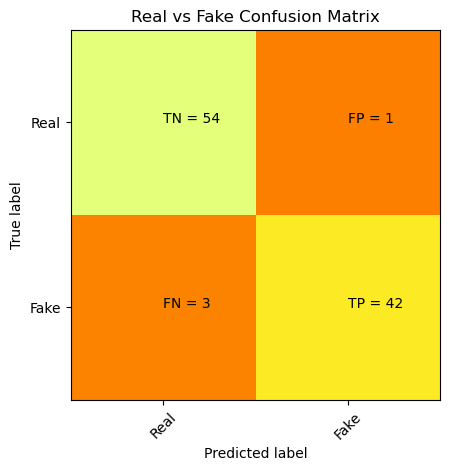


<---- ROC-AUC ---->

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.995



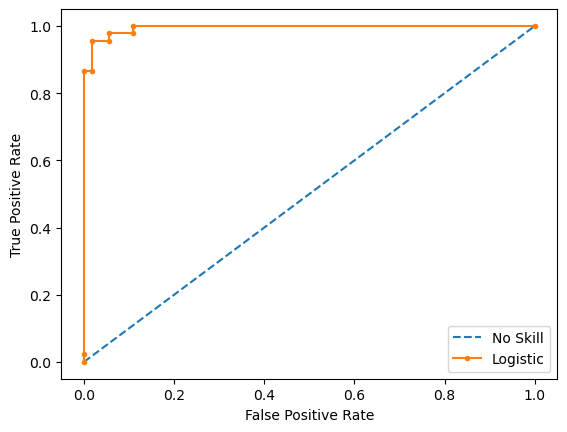

In [59]:
#run model on 16k
model_svm_2 = svm.SVC(probability=True)
run_model_on_test_data(model_svm_2, X_train_final, X_test, y_train_final, y_test, feature_index_2)

In [73]:
#select features identified from brute force
selected_features_3 = bruteforce_df[(bruteforce_df["features"].str.contains("zcr")) & (bruteforce_df.iloc[:,1:] > 0.80).any(axis=1)]['features']
selected_features_3

96         pcm_zcr_sma_quartile1
102    pcm_zcr_sma_percentile1.0
Name: features, dtype: object

In [74]:
feature_index_3 = timit_df.columns.intersection(selected_features_3)
feature_index_3

Index(['pcm_zcr_sma_quartile1', 'pcm_zcr_sma_percentile1.0'], dtype='object')

<---- Train and Test Accuracy ---->

Logistic accuracy train = 89.333
Logistic accuracy test = 85.000

<---- Classification Report ---->

              precision    recall  f1-score   support

           0       0.84      0.89      0.87        55
           1       0.86      0.80      0.83        45

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100


<---- Confusion Matrix ---->



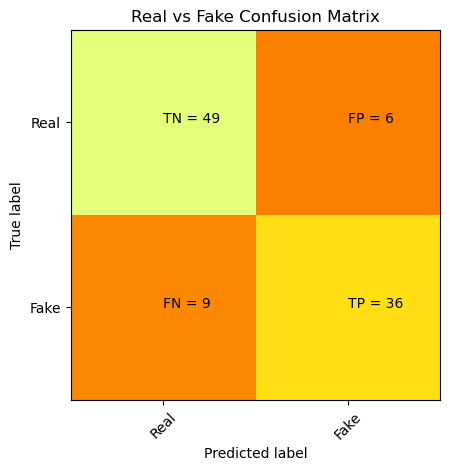


<---- ROC-AUC ---->

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.918



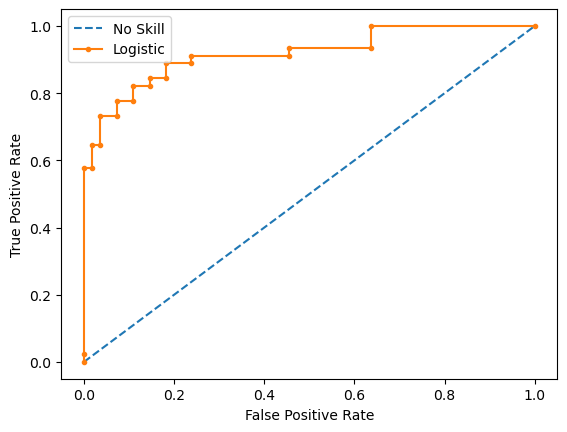

In [75]:
#run model on 16k
model_svm_3 = svm.SVC(probability=True)
run_model_on_test_data(model_svm_3, X_train_final, X_test, y_train_final, y_test, feature_index_3)